# 5.30.Thurs   IMDB    2017130772 정준영

영화 리뷰(텍스트)를 분석해 그 영화의 총 평이 good인지 bad인지 판단하게(binary) model을 만들자.

IMDB MODEL 필기 사진 첨부

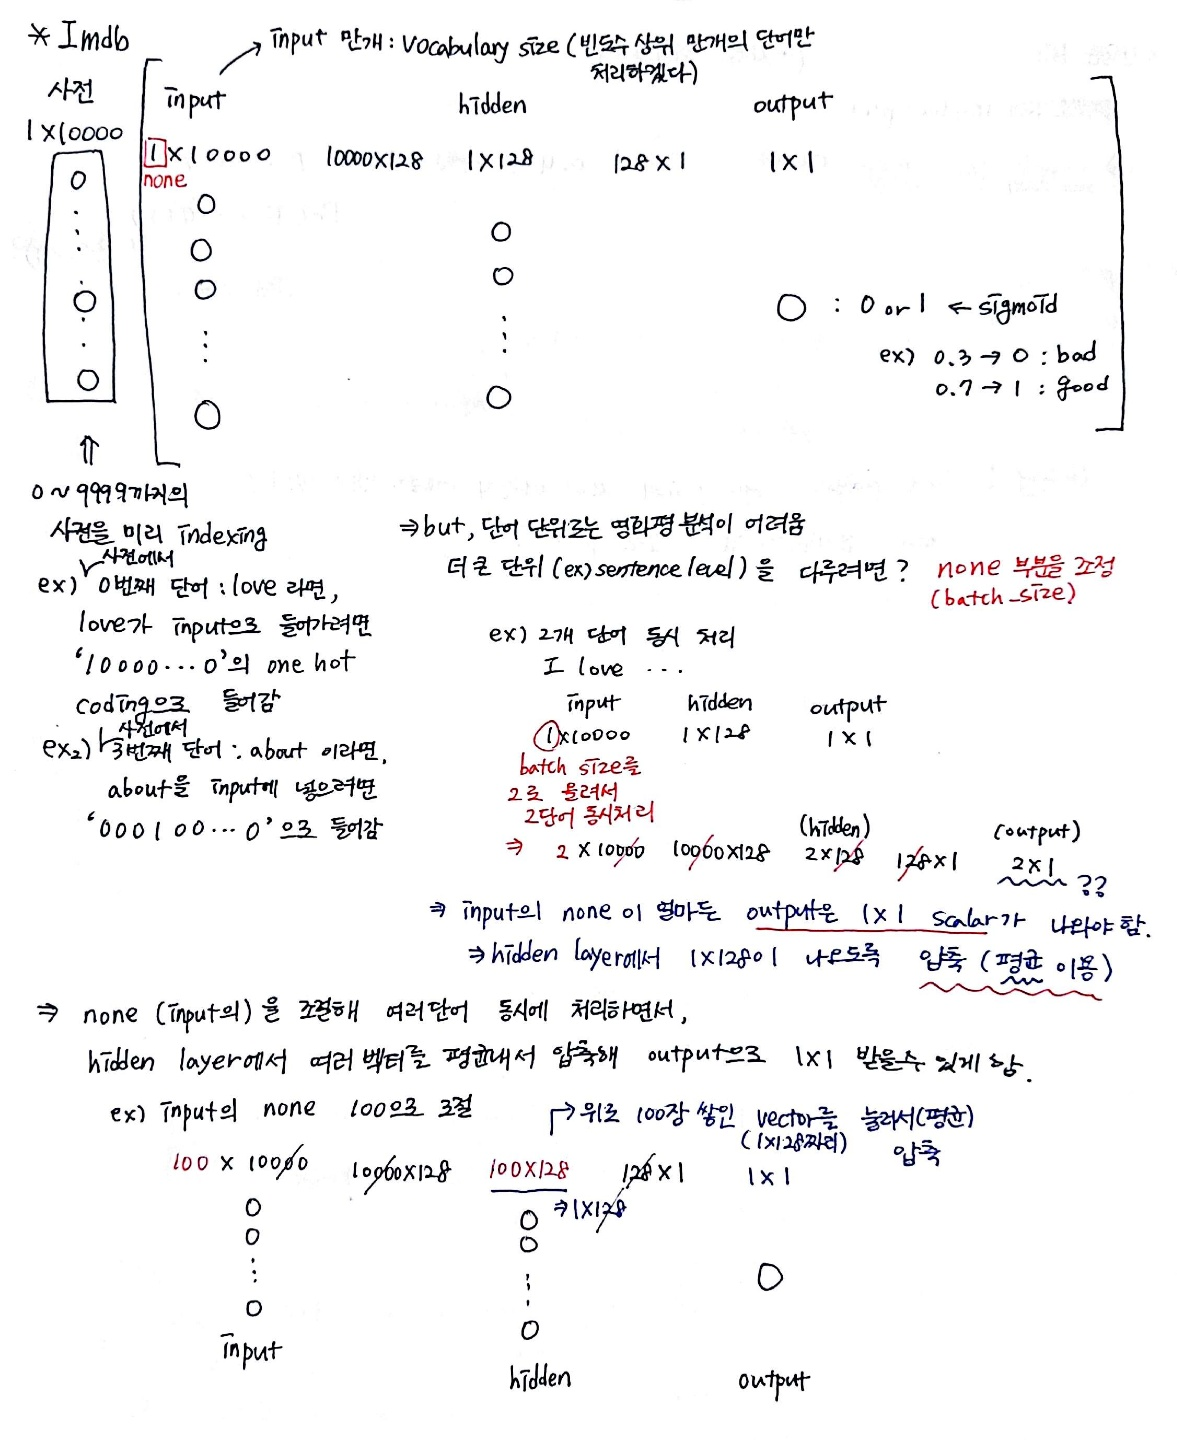

### Import modules

In [1]:
# TensorFlow and tf.keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

### load data 
- #### dataset (x: imdb article -> y: text type)
- #### word2idx dict (key: word; value: index)

In [2]:
# x는 imdb에 있는 영화평 text(단어의 번호들), y는 좋은지 나쁜지 정답값(0=bad, 1=good)
vocab_size = 10000   # input의 node의 갯수, data에서 빈도를 기반으로 최빈 10000개 단어만 가지고 model 만들겠다(나머지 단어는 unknown으로 처리-imdb 영화평은 아마 단어가 만개 이상 존재할 테니, unk 존재)
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.imdb.load_data(num_words=vocab_size)
word2idx = tensorflow.keras.datasets.imdb.get_word_index()   # 사전

In [19]:
print(x_train.shape)
print(x_train[0])   # 10000보다 큰 수는 볼 수 없음.(만까지만 번호를 매겼기 때문)
print(y_train[0])
# print(word2idx) # 단어와 그 단어에 매겨진 번호를 볼 수 있음(10000넘는 수도 볼 수 있음-사전이니까)

(25000, 256)
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   2

### modifiy word2idx dict (to reflect x_train, x_text)

In [4]:
len(word2idx)   # 사전에 있는 단어의 수

88584

In [5]:
word2idx = {k:v+3 for k, v in word2idx.items()}  # 88584번 for loop가 돌아감.  # dict 형태니까 key와 value를 동시에 받아야 함.
# 각 item에 대해서 key와 value가 받아지는 list comprehension 
# 모든 index value값에 3을 더해주면서 받음(WHY? pad, start와 같이 추가로 사전에 넣어주고 싶은게 있으니까 기존의 value값은 뒤로 미뤄줌)
# start, unk 등이 숫자로 처리되어야 처리할 수 있기 때문
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

### create idx2word: inverse of word2idx

- 역사전 만듦, 숫자로 도출된 것들을 다시 단어로 보고 싶으면 역사전이 필요하기 때문 : v 와 k 위치 변경

In [6]:
idx2word = {v:k for k, v in word2idx.items()}

### padding x_train, x_test

In [7]:
len(x_train[0])  # padding 전 상태 = 256개 아님.

218

In [8]:
# x_train의 모든 것들을, 넘치는 것을 자르든지 모자라면 붙이든지 해서 전부 256개의 길이가 되도록 만들어줌 = padding
x_train = pad_sequences(x_train, value=word2idx['<PAD>'], padding='post', maxlen=256)  # 모자라면 뒷부분에 padding해주어라.
x_test = pad_sequences(x_test, value=word2idx['<PAD>'], padding='post', maxlen=256)

In [9]:
print(len(x_train[0]))  # padding 후 상태 = 256개 
print(x_train[0])   # 뒷부분이 0으로 채워진 것을 볼 수 있음. 이 상태가 input들어가기 직전의 상태

256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
  

### create model

- Embedding : 숫자 하나가 만개의 벡터가 되게, 즉 one hot coding이 되도록 바꾸어 주어야 함.  ex) 숫자 1 : 01000000...(만 개)
              즉, 256 * 10000의 벡터가 되도록 해주는 것이 embedding (숫자 하나 1 * 1을 1 * 10000으로 바꾸어 주는 것)
              Embedding이 끝나면 256 * 10000의 벡터에는 256개의 1이 들어있을 것.
- GlobalAveragePooling1D : hidden layer는 항상 256 * 128의 matrix.  평균 작업은 총 128번 함. 한번의 평균 작업당 256개의 숫자를 평균 냄. 
                           평균 작업 후에는 1 * 128의 벡터가 될 것. (128짜리 벡터가 위로 256개 쌓여있다고 생각)

embedding 필기 이미지 첨부

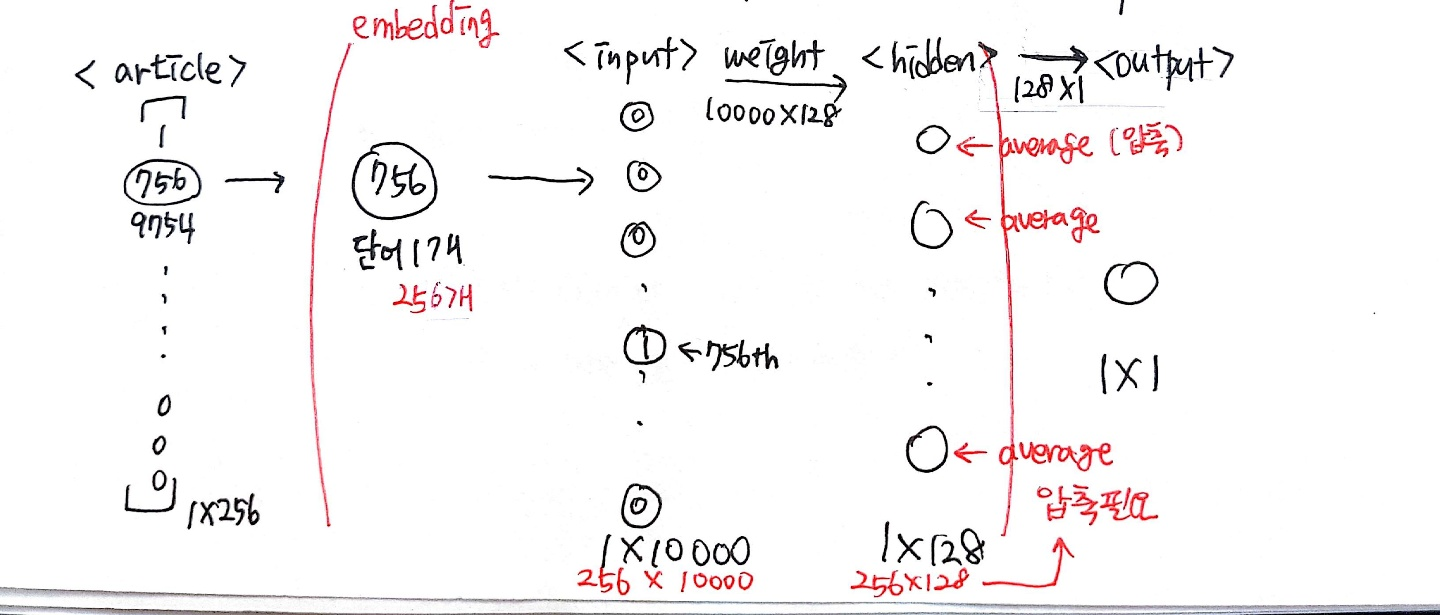

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, 128, 256))  # vocab_size만큼 one hot coding됨(input의 node 수=vocab_size), 중간 요소 128은 hidden layer node의 수, 마지막 요소 256은 input의 length(몇번 input들어오는가=단어의 수만큼 들어온다=256)   
# hidden layer node만드는 것까지가 embedding
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [12]:
Adam = tensorflow.keras.optimizers.Adam
model.compile(optimizer = Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
print(model.input_shape)
print(model.output_shape)

(None, None)
(None, 1)


### train model

In [14]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.33)

Train on 16750 samples, validate on 8250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
16750/16750 [==============================] - 18s 1ms/sample - loss: 0.6566 - acc: 0.7105 - val_loss: 0.5892 - val_acc: 0.7851
Epoch 2/10
16750/16750 [==============================] - 15s 878us/sample - loss: 0.5075 - acc: 0.8264 - val_loss: 0.4466 - val_acc: 0.8373
Epoch 3/10
16750/16750 [==============================] - 15s 868us/sample - loss: 0.3883 - acc: 0.8685 - val_loss: 0.3699 - val_acc: 0.8616
Epoch 4/10
16750/16750 [==============================] - 16s 939us/sample - loss: 0.3225 - acc: 0.8866 - val_loss: 0.3305 - val_acc: 0.8730
Epoch 5/10
16750/16750 [==============================] - 14s 844us/sample - loss: 0.2816 - acc: 0.9012 - val_loss: 0.3075 - val_acc: 0.8802
Epoch 6/10
16750/16750 [==============================] - 17s 993us/sample - loss: 0.2521 - acc: 0.9117 - val_loss: 0.2937 - val_acc: 0.8842
Epoch 7/10
16750/16750 [==============================] - 1

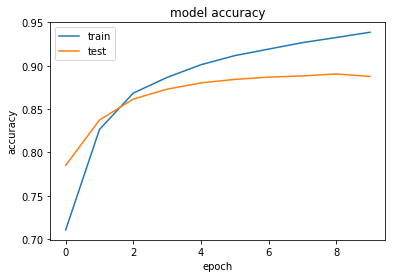

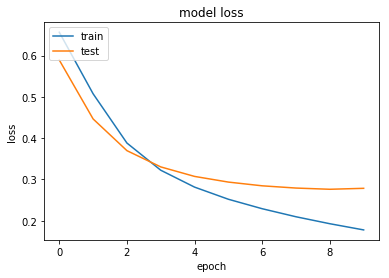

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### test model

In [16]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 4s 153us/sample - loss: 0.2911 - acc: 0.8801


[0.291066909866333, 0.88012]

### inference

In [17]:
testID = 100
print(' '.join([idx2word[idx] for idx in x_test[testID]]))

out = model.predict(x_test[testID].reshape(1,256))   # 한 review의 단어의 수를 동일하게 정해주어야 함.(현재 256개로 정해져있음-data의 review가 256개보다 많으면 잘려나가고, 모자라면 PAD로 처리됨.)
print(y_test[testID])
print(out)

<START> a quick glance at the premise of this film would seem to indicate just another dumb <UNK> <UNK> <UNK> slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread <UNK> tension amidst a lovely <UNK> backdrop these feelings are further <UNK> by a cast of realistically likable characters and <UNK> that are more amoral than cardboard <UNK> of evil oh yeah george kennedy is here too and when is that not a good thing br br if you liked wrong turn then watch this to see where much of its' <UNK> came from <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

In [18]:
print(x_test[100])   # start가 1, a 가 6, quick 이 1605번 ...
print(len(x_test[100]))  # 이 review에는 256개의 단어가 있음(padding). 256에서 모자란 갯수는 PAD로 채워짐.

[   1    6 1605 7334   33    4  863    7   14   22   62  306    8 7147
   43  160  995    2    2    2 8462 3340    4  552  121  383 9538  341
    5    4  156   26   32  616 2118   25  165  181    8  783  190 1545
 5779   53   10   10  247   74 1152   23 3883 2120    5  599  151   50
    9    6  117    7  257   57  383  190    4  509 2679   23 4498 8153
 6249    2 1074 6929    6 1334    2 4157  134 1417   26 1037    2   34
    6  177    7 7292 1451  105    5    2   15   26   53 8955   74 3440
    2    7  445  449 1243  742 4224    9  133   99    5   54    9   15
   24    6   52  155   10   10   48   25  423  355  471   95  106   14
    8   67  121   76    7 9665    2  385   39    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 